<a href="https://colab.research.google.com/github/JScottLopez/JScottLopez/blob/main/Lopez_J_DDS_8555v1_Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Author: Joseph Lopez
#4/11/2025

#Install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)

#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###Store Sales Time Series Forecasting
#Load data and preprocess
ss_train = pd.read_csv('/content/drive/MyDrive/ss_train.csv')
ss_test = pd.read_csv('/content/drive/MyDrive/ss_test.csv')
ss_stores = pd.read_csv('/content/drive/MyDrive/ss_stores.csv')
ss_oil = pd.read_csv('/content/drive/MyDrive/ss_oil.csv')
ss_holidays = pd.read_csv('/content/drive/MyDrive/ss_holidays.csv')
ss_transactions = pd.read_csv('/content/drive/MyDrive/ss_transactions.csv')
#Ensure output meets submission requirements
target_size = 28513
if len(ss_train) > target_size:
  train = ss_train.sample(n=target_size, random_state=42)
#Convert date to datetime
ss_train['date'] = pd.to_datetime(ss_train['date'])
ss_test['date'] = pd.to_datetime(ss_test['date'])
ss_oil['date'] = pd.to_datetime(ss_oil['date'])
ss_holidays['date'] = pd.to_datetime(ss_holidays['date'])
ss_transactions['date'] = pd.to_datetime(ss_transactions['date'])
#Merge datasets
train_with_oil = ss_train.merge(ss_oil, on='date', how='left')
train_with_holidays = train_with_oil.merge(ss_holidays, on='date', how='left')
#Check merging results
print("shape after merging with oil:", train_with_oil.shape)
print("Shape after merging with holidays:", train_with_holidays.shape)

shape after merging with oil: (3000888, 7)
Shape after merging with holidays: (3054348, 12)


In [ ]:
#Filter data for ETS model
def create_ets_model(df, store_nbr, family):
  df_filtered = df[(df['store_nbr'] == store_nbr) & (df['family'] == family)]
  #Set date as index and resample to daily freq
  df_filtered = df_filtered.set_index('date')
  df_daily = df_filtered['sales'].resample('D').sum().fillna(0)
  #Check for nulls
  if df_daily.empty:
    print(f"Warning: Dataframe is empty for store_nbr={store_nbr} and family={family}. Skipping this combination.")
    return None, None, None, None, None
  #Split data
  train, test = train_test_split(df_daily, test_size=0.2, shuffle=False)
  #Fit model
  model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
  fit = model.fit()
  #Make predictions
  forecast = fit.forecast(len(test))
  #Calculate metrics
  mse = mean_squared_error(test, forecast)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test, forecast)
  return fit, forecast, mse, rmse, mae

In [ ]:
#ETS Model
#Function to make predictions for all store-family combinations
def predict_all(train_data, test_data):
  all_predictions = []
  all_metrics = {'mse': [], 'rmse': [], 'mae': []}
  #Iterate through unique store and family combinations
  for store_nbr in train_data['store_nbr'].unique():
    for family in train_data['family'].unique():
      #Filter training data for combinations
      train_filtered = train_data[(train_data['store_nbr'] == store_nbr) & (train_data['family'] == family)]
      train_filtered = train_filtered.set_index('date')
      train_filtered = train_filtered['sales'].resample('D').sum().fillna(0)
      #Check for enough data for model
      if len(train_filtered) < 7:
        print(f"Warning: Insufficient data for store_nbr={store_nbr} and family={family}. Skipping this combination.")
        continue
      #Filter test data for current store-family combinations
      test_filtered = test_data[(test_data['store_nbr'] == store_nbr) & (test_data['family'] == family)]
      num_predictions = len(test_filtered)
      #Create model use ETS for current store-family combination
      fit, forecast, mse, rmse, mae = create_ets_model(train_data, store_nbr, family)
      #Add metrics to overall metrics
      if fit is not None:
        all_metrics['mse'].append(mse)
        all_metrics['rmse'].append(rmse)
        all_metrics['mae'].append(mae)
      #Prepare predictions Ids
      ids_for_prediction = test_filtered['id'].values
      forecast_values = forecast.values[:len(ids_for_prediction)]
      if len(forecast_values) < len(ids_for_prediction):
        last_forecast_value = forecast.values[-1] if forecast_values else 0
        forecast_values = np.pad(forecast_values, (0, len(ids_for_prediction) - len(forecast_values)), 'constant', constant_values=last_forecast_value)
      #Make predictions df
      predictions = pd.DataFrame({'id': ids_for_prediction, 'sales': forecast_values})
      all_predictions.append(predictions)
  if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
  else:
    final_predictions = pd.DataFrame(columns=['id', 'sales'])
    print("Warning: all_predictions list is empty")
  #Calculate overall metrics
  overall_mse = np.mean(all_metrics['mse'])
  overall_rmse = np.mean(all_metrics['rmse'])
  overall_mae = np.mean(all_metrics['mae'])
  print("\nOverall Metrics:")
  print(f"Overall MSE: {overall_mse:.2f}")
  print(f"Overall RMSE: {overall_rmse:.2f}")
  print(f"Overall MAE: {overall_mae:.2f}")
  return final_predictions
#Generate final predictions
final_predictions = predict_all(train_with_holidays, ss_test)
#Convert to CSV
submission1 = final_predictions[['id', 'sales']]


Overall Metrics:
Overall MSE: 545806.65
Overall RMSE: 245.91
Overall MAE: 168.83


In [ ]:
#Filter data for ARIMA model
def create_arima_model(df, store_nbr, family):
  df_filtered = df[(df['store_nbr'] == store_nbr) & (df['family'] == family)]
  #Set date as index and resample to daily freq
  df_filtered = df_filtered.set_index('date')
  df_daily = df_filtered['sales'].resample('D').sum().fillna(0)
  #Check for nulls
  if df_daily.empty:
    return None, None, None, None, None
  #Split data
  train, test = train_test_split(df_daily, test_size=0.2, shuffle=False)
  #Fit model
  try:
    model = ARIMA(train, order=(1, 1, 1))
    fit = model.fit()
  except:
    return None, None, None, None, None
  #Make predictions
  forecast = fit.forecast(len(test))
  #Calculate metrics
  mse = mean_squared_error(test, forecast)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test, forecast)
  return fit, forecast, mse, rmse, mae

In [ ]:
#ARIMA model
#Function to make predictions for all store-family combinations
def predict_all(train_data, test_data):
  all_predictions = []
  all_metrics = {'mse': [], 'rmse': [], 'mae': []}
  #Iterate through unique store and family combinations
  for store_nbr in train_data['store_nbr'].unique():
    for family in train_data['family'].unique():
      #Filter training data for combinations
      train_filtered = train_data[(train_data['store_nbr'] == store_nbr) & (train_data['family'] == family)]
      train_filtered = train_filtered.set_index('date')
      train_filtered = train_filtered['sales'].resample('D').sum().fillna(0)
      #Check for enough data for model
      if len(train_filtered) < 7:
        print(f"Warning: Insufficient data for store_nbr={store_nbr} and family={family}. Skipping this combination.")
        continue
      #Filter test data for current store-family combinations
      test_filtered = test_data[(test_data['store_nbr'] == store_nbr) & (test_data['family'] == family)]
      num_predictions = len(test_filtered)
      #Create model use ETS for current store-family combination
      fit, forecast, mse, rmse, mae = create_arima_model(train_data, store_nbr, family)
      #Add metrics to overall metrics
      if fit is not None:
        all_metrics['mse'].append(mse)
        all_metrics['rmse'].append(rmse)
        all_metrics['mae'].append(mae)
      #Prepare predictions Ids
      ids_for_prediction = test_filtered['id'].values
      forecast_values = forecast.values[:len(ids_for_prediction)]
      if len(forecast_values) < len(ids_for_prediction):
        last_forecast_value = forecast.values[-1] if forecast_values else 0
        forecast_values = np.pad(forecast_values, (0, len(ids_for_prediction) - len(forecast_values)), 'constant', constant_values=last_forecast_value)
      #Make predictions df
      predictions = pd.DataFrame({'id': ids_for_prediction, 'sales': forecast_values})
      all_predictions.append(predictions)
  if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
  else:
    final_predictions = pd.DataFrame(columns=['id', 'sales'])
  #Calculate overall metrics
  overall_mse = np.mean(all_metrics['mse'])
  overall_rmse = np.mean(all_metrics['rmse'])
  overall_mae = np.mean(all_metrics['mae'])
  print("\nOverall Metrics:")
  print(f"Overall MSE: {overall_mse:.2f}")
  print(f"Overall RMSE: {overall_rmse:.2f}")
  print(f"Overall MAE: {overall_mae:.2f}")
  return final_predictions
#General final predictions
final_predictions = predict_all(train_with_holidays, ss_test)
#Convert to CSV
submission2 = final_predictions[['id', 'sales']]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.p


Overall Metrics:
Overall MSE: 351393.45
Overall RMSE: 216.44
Overall MAE: 138.25


In [ ]:
###House Prices Advanced Regression Techniques
#Load data from a CSV file
hp_train = pd.read_csv('/content/drive/MyDrive/hp_train.csv')
hp_test = pd.read_csv('/content/drive/MyDrive/hp_test.csv')
#Combine train and test data for preprocessing
all_data = pd.concat([hp_train.drop('SalePrice', axis=1), hp_test.drop('Id', axis=1)], axis=0)
#Preprocess data
def preprocess_data(df):
  #Convert categorical columns to numerical
  categorical_cols = df.select_dtypes(include=['object']).columns
  df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
  #Create dichotomous variables
  df['IsNew'] = (df['YearBuilt'] > 2000).astype(int)
  #Impute missing values with the mean
  numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
  df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
  return df
all_data_preprocessed = preprocess_data(all_data)
#Split back into train and test
X = all_data_preprocessed[:len(hp_train)]
test_data = all_data_preprocessed[len(hp_train):]
#Ensure output meets submission requirements
target_size = 1460
if len(X) > target_size:
  hp_train = hp_train.sample(n=target_size, random_state=42)
#Prepare target
y = hp_train['SalePrice']
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
test_data_scaled = scaler.transform(test_data)
#Perform PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
test_data_pca = pca.transform(test_data_scaled)

Mean Squared Error: 1357698904.9294124
Mean Absolute Error: 23709.975594112326


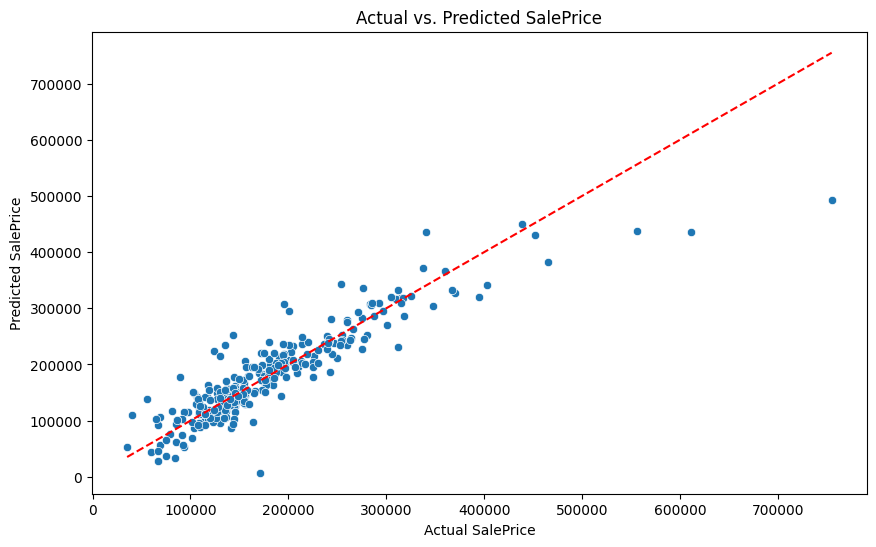

In [ ]:
#Lasso Regression
#Initialize and fit model
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model.fit(X_train_pca, y_train)
#Make predictions
y_pred = lasso_model.predict(X_test_pca)
#Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
#Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs. Predicted SalePrice')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()
#Convert to CSV
submission_preds = lasso_model.predict(test_data_pca)
submission3 = pd.DataFrame({'Id': hp_test['Id'], 'SalePrice': submission_preds})

Mean Squared Error: 1358056947.033149
Mean Absolute Error: 23714.740371391028


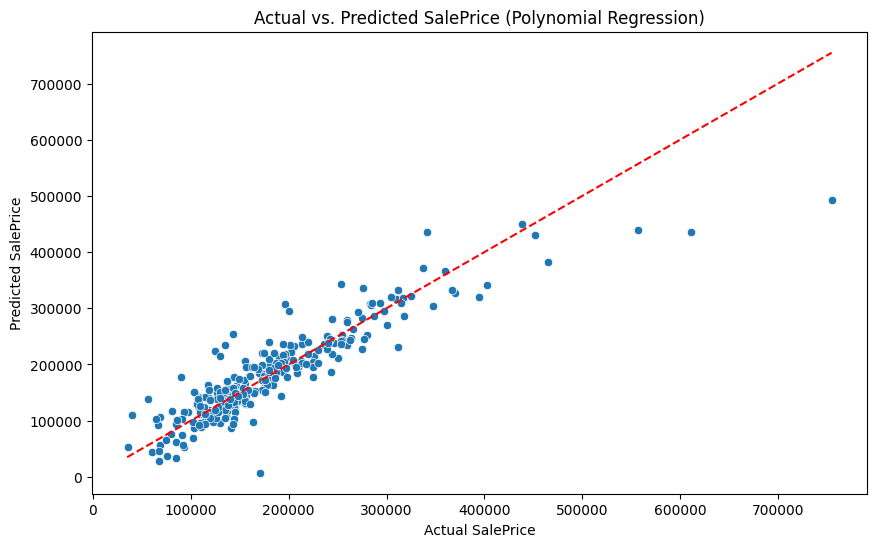

In [ ]:
#Polynomial Regression
#Initialize and fit model
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_pca, y_train)
#Make predictions
y_pred = poly_reg_model.predict(X_test_pca)
#Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
#Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs. Predicted SalePrice (Polynomial Regression)')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.show()
#Convert to CSV
submission_preds = poly_reg_model.predict(test_data_pca)
submission4 = pd.DataFrame({'Id': hp_test['Id'], 'SalePrice': submission_preds})

In [ ]:
###San Francisco Crime Classification
#Load data from a CSV file
cc_train = pd.read_csv('/content/drive/MyDrive/cc_train.csv')
cc_test = pd.read_csv('/content/drive/MyDrive/cc_test.csv')

#Ensure output meets submission requirements
target_size = 884261
if len(cc_train) > target_size:
  cc_train = cc_train.sample(n=target_size, random_state=42)

#Subset columns
X = cc_train.drop(['Dates', 'Category', 'Descript', 'Resolution', 'Address'], axis=1)
y = cc_train['Category']

#Use one-hot encoding
X = pd.get_dummies(X, columns=['PdDistrict', 'DayOfWeek'], drop_first=True)

#Take sample from large train set
sample_size = 5000
if len(X) > sample_size:
  X, y = X.sample(n=sample_size, random_state=42), y.sample(n=sample_size, random_state=42)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Use PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Confusion Matrix: 
[[0 0 0 ... 0 0 0]
 [0 8 0 ... 4 2 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 5 2 0]
 [0 6 0 ... 3 1 2]
 [0 2 0 ... 0 0 0]]

Classification Report:
                             precision    recall  f1-score   support

                    ASSAULT       0.13      0.09      0.11        91
                 BAD CHECKS       0.00      0.00      0.00         1
                   BURGLARY       0.08      0.08      0.08        53
         DISORDERLY CONDUCT       0.00      0.00      0.00         1
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00         2
              DRUG/NARCOTIC       0.24      0.22      0.23        65
                DRUNKENNESS       0.00      0.00      0.00         8
     FORGERY/COUNTERFEITING       0.00      0.00      0.00        16
                      FRAUD       0.00      0.00      0.00        17
                 KIDNAPPING       0.00      0.00      0.00         2
              LARCENY/THEFT       0.28      0.36      0.31       195
        

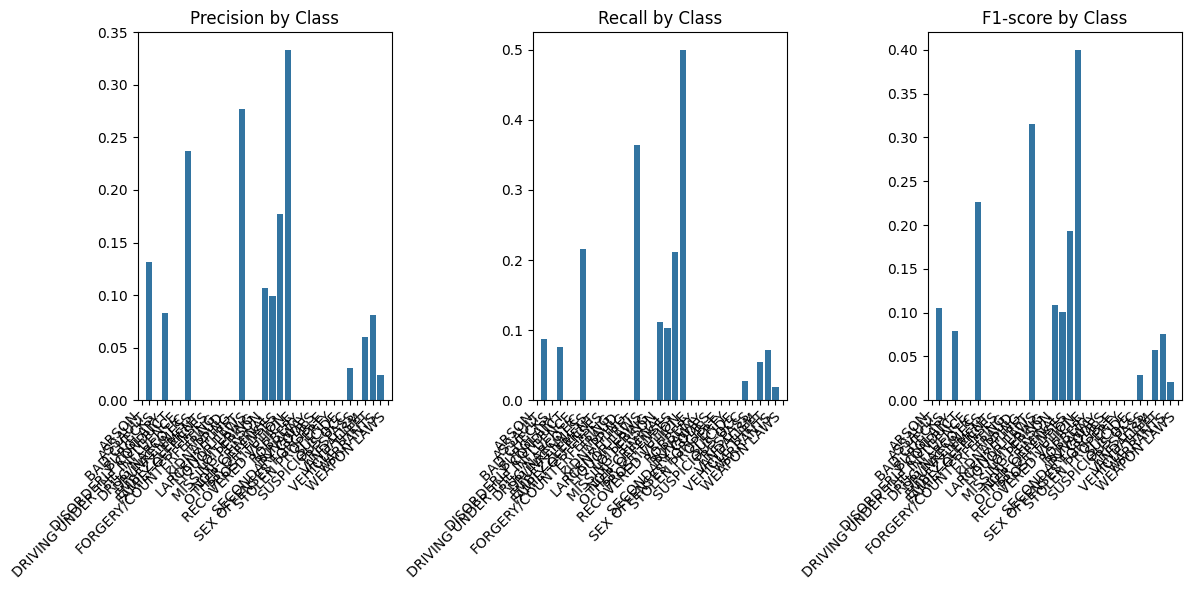

In [ ]:
#Random Forest Model
#Initialize and fit model
RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train_pca, y_train)
#Make predictions
y_pred = RF_model.predict(X_test_pca)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ')
print(cm)
print('\nClassification Report:')
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(classification_report(y_test, y_pred,labels=np.unique(y_pred), zero_division=0))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert to CSV
test_data_for_prediction = cc_test.drop('Id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
  test_data_for_prediction[col] = 0
for col in ['PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE', 'TREA']:
  if col not in test_data_for_prediction.columns:
    test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
test_data_scaled = scaler.transform(test_data_for_prediction)
test_data_pca = pca.transform(test_data_scaled)
predicted_probabilities = RF_model.predict_proba(test_data_pca)
submission5 = pd.DataFrame(predicted_probabilities, columns=RF_model.classes_)
for col in ['PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE', 'TREA']:
  if col not in submission5.columns:
    submission5[col] = 0
submission5.insert(0, 'Id', cc_test['Id'])

Confustion Matrix: 
[[ 0  0  0 ...  0  0  0]
 [ 0 11  0 ...  3  3  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  3  0 ...  7  2  0]
 [ 0  2  0 ...  4  1  3]
 [ 0  0  0 ...  0  0  0]]

Classification Report:
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00         1
                    ASSAULT       0.29      0.12      0.17        91
                   BURGLARY       0.10      0.06      0.07        53
         DISORDERLY CONDUCT       0.00      0.00      0.00         1
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00         2
              DRUG/NARCOTIC       0.27      0.17      0.21        65
                DRUNKENNESS       0.00      0.00      0.00         8
            FAMILY OFFENSES       0.00      0.00      0.00         1
     FORGERY/COUNTERFEITING       0.00      0.00      0.00        16
                      FRAUD       0.00      0.00      0.00        17
                 KIDNAPPING       0.00  

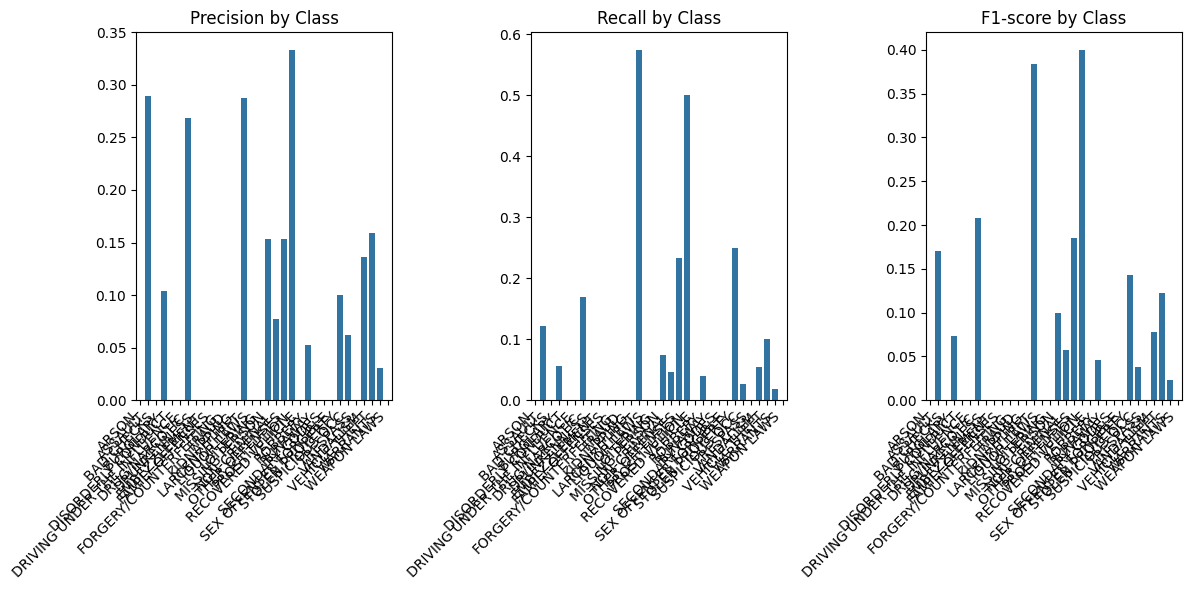

In [ ]:
#Gradient Boosted Model
#Initialize and fit model
GB_model = GradientBoostingClassifier(random_state=42)
GB_model.fit(X_train_pca, y_train)
#Make predictions
y_pred = GB_model.predict(X_test_pca)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confustion Matrix: ')
print(cm)
print('\nClassification Report:')
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(classification_report(y_test, y_pred,labels=np.unique(y_pred), zero_division=0))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert to CSV
test_data_for_prediction = cc_test.drop('Id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
  test_data_for_prediction[col] = 0
for col in ['PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE', 'TREA']:
  if col not in test_data_for_prediction.columns:
    test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
test_data_scaled = scaler.transform(test_data_for_prediction)
test_data_pca = pca.transform(test_data_scaled)
predicted_probabilities = GB_model.predict_proba(test_data_pca)
submission6 = pd.DataFrame(predicted_probabilities, columns=GB_model.classes_)
for col in ['PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE', 'TREA']:
  if col not in submission6.columns:
    submission6[col] = 0
submission6.insert(0, 'Id', cc_test['Id'])

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]

Classification Report: 
                precision    recall  f1-score   support

       ASSAULT       0.00      0.00      0.00        91
      BURGLARY       0.00      0.00      0.00        53
 DRUG/NARCOTIC       0.27      0.26      0.27        65
 LARCENY/THEFT       0.26      0.73      0.39       195
  NON-CRIMINAL       0.00      0.00      0.00        87
OTHER OFFENSES       0.14      0.35      0.20       137
 VEHICLE THEFT       0.05      0.01      0.02        70

     micro avg       0.21      0.30      0.24       698
     macro avg       0.10      0.19      0.13       698
  weighted avg       0.13      0.30      0.17       698



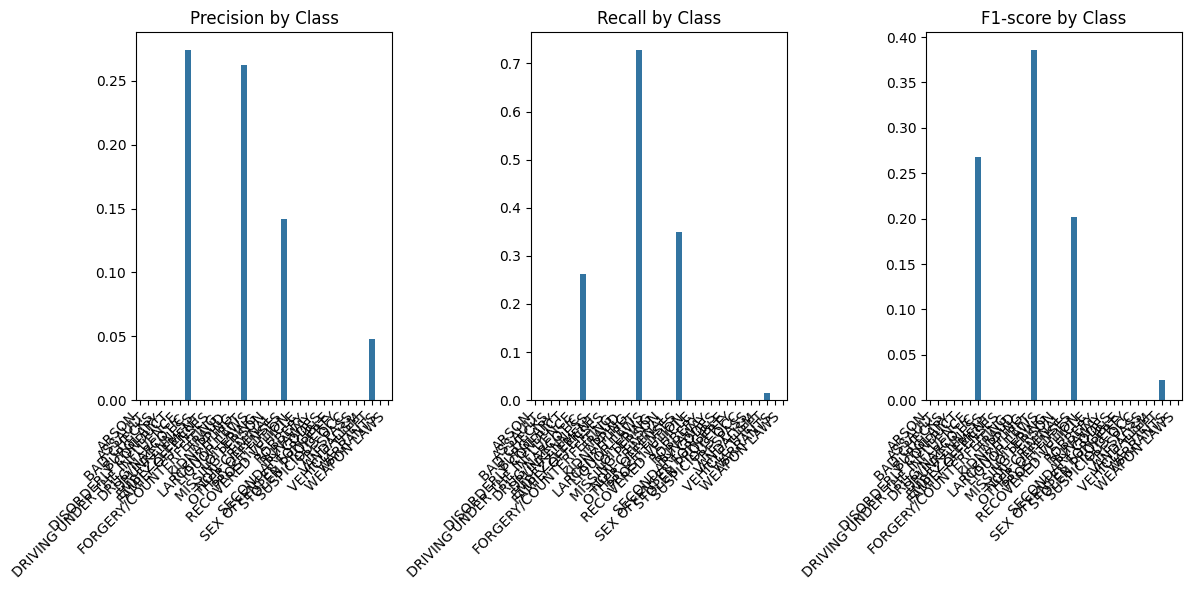

In [ ]:
#SVM Model
#Initialize and fit model
SVM_model = SVC(random_state=42, probability=True)
SVM_model.fit(X_train_pca, y_train)
#Make predictions
y_pred = SVM_model.predict(X_test_pca)
#Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('\nClassification Report: ')
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(classification_report(y_test, y_pred,labels=np.unique(y_pred), zero_division=0))
#Plot results
plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics, 1):
  plt.subplot(1, 3, i)
  labels = list(cr.keys())[:-3]
  sns.barplot(x=labels, y=[cr[label][metric] for label in labels])
  plt.title(f'{metric.capitalize()} by Class')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
plt.show()
#Convert to CSV
test_data_for_prediction = cc_test.drop('Id', axis=1)
missing_cols = set(X_train.columns) - set(test_data_for_prediction.columns)
for col in missing_cols:
  test_data_for_prediction[col] = 0
for col in ['PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE', 'TREA']:
  if col not in test_data_for_prediction.columns:
    test_data_for_prediction[col] = 0
test_data_for_prediction = test_data_for_prediction[X_train.columns]
test_data_scaled = scaler.transform(test_data_for_prediction)
test_data_pca = pca.transform(test_data_scaled)
predicted_probabilitites = SVM_model.predict_proba(test_data_pca)
submission7 = pd.DataFrame(predicted_probabilities, columns=SVM_model.classes_)
for col in ['PORNOGRAPHY/OBSCENE MAT', 'SEX OFFENSES NON FORCIBLE', 'TREA']:
  if col not in submission7.columns:
    submission7[col] = 0
submission7.insert(0, 'Id', cc_test['Id'])

In [ ]:
#Convert to CSV files
submission1.to_csv('submission1.csv', index=False)
submission2.to_csv('submission2.csv', index=False)
submission3.to_csv('submission3.csv', index=False)
submission4.to_csv('submission4.csv', index=False)
submission5.to_csv('submission5.csv', index=False)
submission6.to_csv('submission6.csv', index=False)
submission7.to_csv('submission7.csv', index=False)